# PHÁT HIỆN GIAN LẬN TÀI KHOẢN NGÂN HÀNG


## Khai báo thư viện và Cấu hình hệ thống

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import os
import glob
import joblib
import warnings

# Các thư viện Scikit-learn & Imbalanced-learn
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler # <--- Dùng kỹ thuật Giảm mẫu
from collections import Counter

# Cấu hình hệ thống
warnings.filterwarnings('ignore') # Tắt các cảnh báo đỏ
pd.set_option('display.max_columns', None) # Hiển thị tất cả cột
plt.style.use('ggplot') # Giao diện biểu đồ

## Tải và Khám phá dữ liệu gốc

In [44]:
# Tự động tìm file Base.csv
matches = glob.glob(os.path.join("**", "Base.csv"), recursive=True)
path = matches[0] if matches else glob.glob("**/*.csv", recursive=True)[0]
df = pd.read_csv(path)

print("--- 5 DÒNG ĐẦU TIÊN ---")
display(df.head())

print("\n--- THÔNG TIN CẤU TRÚC DỮ LIỆU ---")
df.info()

print("\n--- THỐNG KÊ MÔ TẢ ---")
display(df.describe())

--- 5 DÒNG ĐẦU TIÊN ---


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,13096.035018,7850.955007,6742.080561,5,5,CB,163,1,BC,0,1,9,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,9223.283431,5745.251481,5941.664859,3,18,CA,154,1,BC,1,1,2,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,4471.472149,5471.988958,5992.555113,15,11,CA,89,1,BC,0,1,30,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,14431.993621,6755.344479,5970.336831,11,13,CA,90,1,BC,0,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,7601.511579,5124.046930,5940.734212,1,6,CA,91,0,BC,1,1,26,0,200.0,0,INTERNET,3.743048,other,0,1,0,0



--- THÔNG TIN CẤU TRÚC DỮ LIỆU ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  ve

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,5665.296605,4769.781965,4856.324016,184.361849,9.503544,130.989595,0.529886,0.417077,0.889676,10.839303,0.222988,515.851010,0.025242,7.544940,0.576947,1.018312,0.0,3.288674
std,0.104438,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,3009.380665,1479.212612,919.843934,459.625329,5.033792,69.681812,0.499106,0.493076,0.313293,12.116875,0.416251,487.559902,0.156859,8.033106,0.494044,0.180761,0.0,2.209994
min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,1300.307314,2825.748405,0.000000,0.000000,-170.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.181488,894.000000,3436.365848,3593.179135,4268.368423,1.000000,6.000000,83.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,200.000000,0.000000,3.103053,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-0.830507,1263.000000,5319.769349,4749.921161,4913.436941,9.000000,9.000000,122.000000,1.000000,0.000000,1.000000,5.000000,0.000000,200.000000,0.000000,5.114321,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,1944.000000,7680.717827,5752.574191,5488.083356,25.000000,13.000000,178.000000,1.000000,1.000000,1.000000,25.000000,0.000000,500.000000,0.000000,8.866131,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16715.565404,9506.896596,6994.764201,2385.000000,39.000000,389.000000,1.000000,1.000000,1.000000,32.000000,1.000000,2100.000000,1.000000,85.899143,1.000000,2.000000,0.0,7.000000


## Chia tập dữ liệu (Temporal Split)

In [45]:
print("[BƯỚC 1.1] CHIA TẬP DỮ LIỆU THEO THỜI GIAN (TEMPORAL SPLIT)...")
train_mask = df['month'] < 6

X_train_raw = df[train_mask].drop(['fraud_bool', 'month'], axis=1)
y_train = df[train_mask]['fraud_bool']

X_test_raw = df[~train_mask].drop(['fraud_bool', 'month'], axis=1)
y_test = df[~train_mask]['fraud_bool']

print(f"   -> Kích thước tập Train: {X_train_raw.shape} | Tỷ lệ gian lận: {y_train.mean():.2%}")
print(f"   -> Kích thước tập Test : {X_test_raw.shape} | Tỷ lệ gian lận: {y_test.mean():.2%}")

[BƯỚC 1.1] CHIA TẬP DỮ LIỆU THEO THỜI GIAN (TEMPORAL SPLIT)...
   -> Kích thước tập Train: (794989, 30) | Tỷ lệ gian lận: 1.03%
   -> Kích thước tập Test : (205011, 30) | Tỷ lệ gian lận: 1.40%


## Phân tích dữ liệu khám phá (EDA)


[BƯỚC 2] PHÂN TÍCH DỮ LIỆU SƠ BỘ (EDA)...


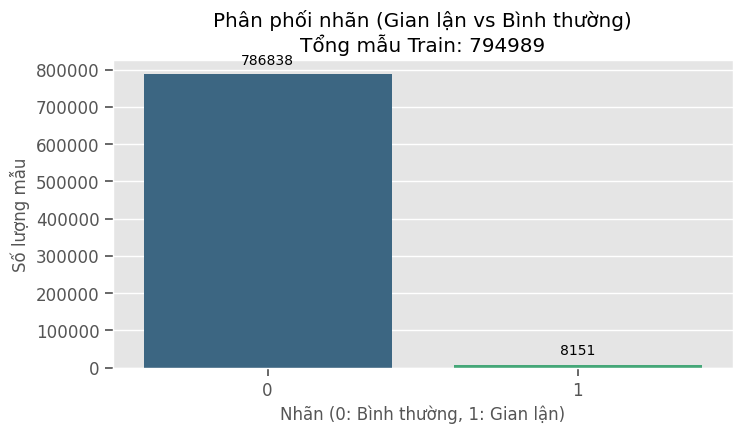

In [46]:
print("\n[BƯỚC 2] PHÂN TÍCH DỮ LIỆU SƠ BỘ (EDA)...")
plt.figure(figsize=(8, 4))
ax = sns.countplot(x=y_train, palette='viridis')
plt.title(f'Phân phối nhãn (Gian lận vs Bình thường)\nTổng mẫu Train: {len(y_train)}')
plt.xlabel('Nhãn (0: Bình thường, 1: Gian lận)')
plt.ylabel('Số lượng mẫu')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

## Tiền xử lý dữ liệu (Preprocessing Pipeline)

In [47]:
def preprocess_pipeline(X_train, X_test):
    print("\n[BƯỚC 3] TIỀN XỬ LÝ DỮ LIỆU...")
    X_train, X_test = X_train.copy(), X_test.copy()
    
    # 3.1. Xử lý giá trị thiếu
    missing_cols = ['prev_address_months_count', 'current_address_months_count', 
                    'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']
    for col in missing_cols:
        if col in X_train.columns:
            median_val = X_train[X_train[col] != -1][col].median()
            X_train.loc[X_train[col] == -1, col] = median_val
            X_test.loc[X_test[col] == -1, col] = median_val

    # 3.2. Feature Engineering
    def create_features(df_feat):
        df_feat = df_feat.copy()
        denom = df_feat['session_length_in_minutes'].replace(0, 0.1) + 1
        df_feat['velocity'] = df_feat['intended_balcon_amount'] / denom
        df_feat['log_amount'] = np.log1p(np.abs(df_feat['intended_balcon_amount']))
        denom_bank = df_feat['bank_months_count'].replace(-1, 0) + 1
        df_feat['age_bank_interact'] = df_feat['customer_age'] * 12 / denom_bank
        return df_feat
    
    X_train = create_features(X_train)
    X_test = create_features(X_test)
    
    # 3.3. Encoding & Scaling
    cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()
    
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
    X_train_cat = pd.DataFrame(ohe.fit_transform(X_train[cat_cols]), index=X_train.index)
    X_test_cat = pd.DataFrame(ohe.transform(X_test[cat_cols]), index=X_test.index)
    
    scaler = RobustScaler()
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
    X_test_num = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)
    
    X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test_final = pd.concat([X_test_num, X_test_cat], axis=1)
    X_train_final.columns = X_train_final.columns.astype(str)
    X_test_final.columns = X_test_final.columns.astype(str)
    
    # 3.4. Feature Selection
    selector = VarianceThreshold(threshold=0)
    selector.fit(X_train_final)
    cols_keep = X_train_final.columns[selector.get_support()]
    X_train_final = X_train_final[cols_keep]
    X_test_final = X_test_final[cols_keep]
    
    imputer = SimpleImputer(strategy='median')
    X_train_final = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns)
    X_test_final = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)
    
    return X_train_final, X_test_final

X_train_proc, X_test_proc = preprocess_pipeline(X_train_raw, X_test_raw)
print(f"Kích thước sau xử lý: {X_train_proc.shape}")
display(X_train_proc.head())


[BƯỚC 3] TIỀN XỬ LÝ DỮ LIỆU...
Kích thước sau xử lý: (794989, 48)


,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,velocity,log_amount,age_bank_interact,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,-0.6,0.909139,0.0,-0.252252,0.5,-0.440239,11.713458,-0.267020,1.722505,1.514336,1.491359,-0.178571,-0.571429,0.438776,0.0,0.0,0.0,-0.30,0.0,4.193548,0.0,1.912639,0.0,0.0,6.898089,2.468768,0.498327,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.4,0.219794,0.0,0.324324,-0.5,-0.267691,-0.003482,0.262599,0.787539,0.387789,0.756553,-0.250000,1.285714,0.346939,0.0,1.0,0.0,-0.65,0.0,4.193548,0.0,-0.326188,0.0,0.0,-0.107540,-0.107684,1.132561,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.4,0.928192,-23.0,-0.351351,0.5,-0.153612,-0.076167,-0.235190,-0.359650,0.241594,0.803271,0.178571,0.285714,-0.316327,0.0,0.0,0.0,0.75,0.0,0.000000,0.0,3.045147,-1.0,0.0,0.042860,0.082784,-0.146137,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,-0.046033,-21.0,-0.351351,0.0,-0.427120,-0.118441,1.876216,2.045034,0.928187,0.782874,0.035714,0.571429,-0.306122,0.0,0.0,0.0,-0.70,0.0,0.000000,0.0,1.736989,0.0,0.0,-0.016547,0.172078,3.114543,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.6,0.639813,0.0,-0.216216,0.5,294.144098,5.441043,0.864721,0.396009,0.055446,0.755698,-0.321429,-0.428571,-0.295918,-1.0,1.0,0.0,0.55,0.0,0.000000,0.0,-0.260178,-1.0,0.0,11.452453,1.979141,-0.100672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Cân bằng dữ liệu (Undersampling)

In [48]:
print("\n[BƯỚC 4] CÂN BẰNG DỮ LIỆU (UNDERSAMPLING)...")
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_proc, y_train)

print(f"   -> Sau khi giảm mẫu: {Counter(y_train_res)}")


[BƯỚC 4] CÂN BẰNG DỮ LIỆU (UNDERSAMPLING)...
   -> Sau khi giảm mẫu: Counter({0: 16302, 1: 8151})


## Mô hình baseline


--- ĐANG HUẤN LUYỆN MÔ HÌNH BASELINE (THAM SỐ MẶC ĐỊNH) ---
   -> Ngưỡng tối ưu Baseline: 0.3715
   -> AUC Score Baseline: 0.8876

--- BÁO CÁO PHÂN LOẠI BASELINE ---
              precision    recall  f1-score   support

 Bình thường       1.00      0.83      0.91    202133
    Gian lận       0.06      0.79      0.11      2878

    accuracy                           0.83    205011
   macro avg       0.53      0.81      0.51    205011
weighted avg       0.98      0.83      0.89    205011



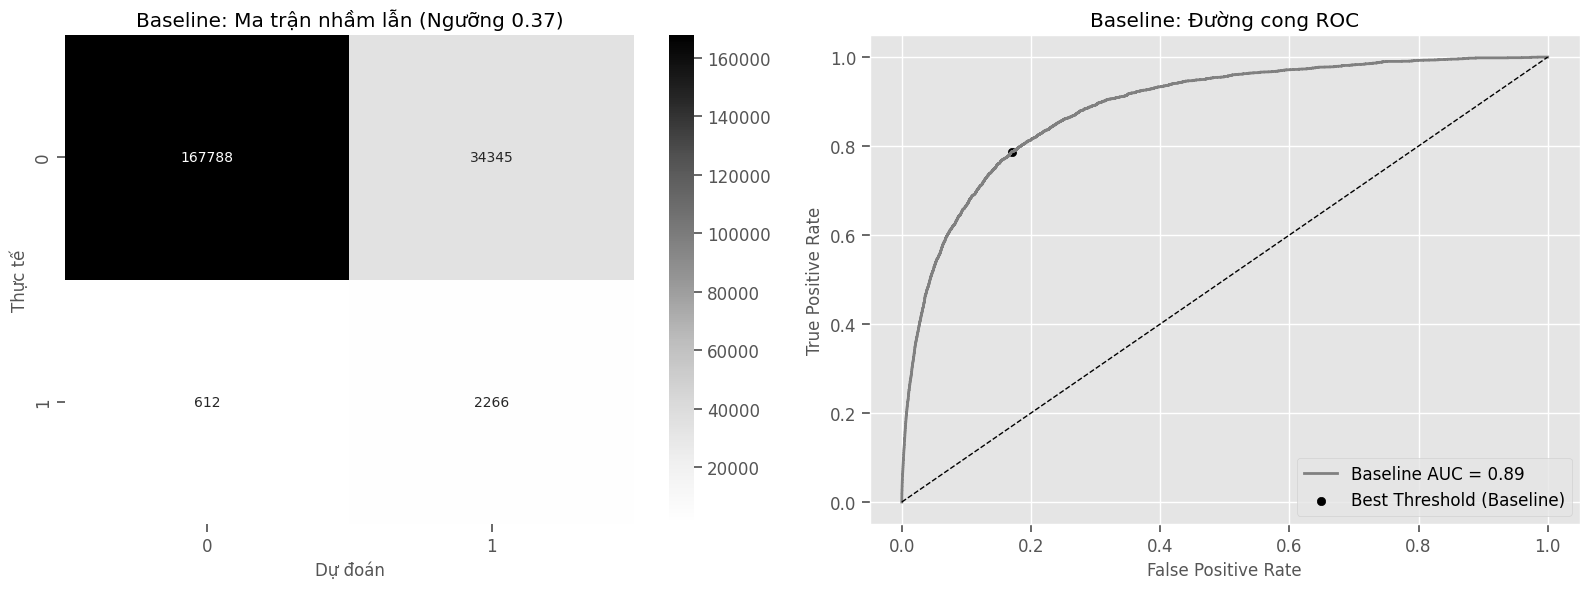

In [ ]:

# [BỔ SUNG] ĐÁNH GIÁ MÔ HÌNH BASELINE 

print("\n--- ĐANG HUẤN LUYỆN MÔ HÌNH BASELINE (THAM SỐ MẶC ĐỊNH) ---")

# 1. Khởi tạo mô hình với tham số mặc định của thư viện
model_base = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)

# 2. Huấn luyện trên cùng một dữ liệu đã giảm mẫu (X_train_res)
model_base.fit(X_train_res, y_train_res)

# 3. Dự đoán xác suất trên tập Test
y_prob_base = model_base.predict_proba(X_test_proc)[:, 1]

# 4. Tính toán ROC và Tìm ngưỡng tối ưu (G-Mean) cho Baseline
fpr_b, tpr_b, thresholds_b = roc_curve(y_test, y_prob_base)
gmeans_b = np.sqrt(tpr_b * (1 - fpr_b))
ix_b = np.argmax(gmeans_b)
best_threshold_b = thresholds_b[ix_b]

# 5. Dự đoán nhãn dựa trên ngưỡng tối ưu
y_pred_base = (y_prob_base >= best_threshold_b).astype(int)

# 6. In kết quả
print(f"   -> Ngưỡng tối ưu Baseline: {best_threshold_b:.4f}")
print(f"   -> AUC Score Baseline: {auc(fpr_b, tpr_b):.4f}")
print("\n--- BÁO CÁO PHÂN LOẠI BASELINE ---")
print(classification_report(y_test, y_pred_base, target_names=['Bình thường', 'Gian lận']))

# 7. Vẽ biểu đồ Ma trận nhầm lẫn và ROC cho Baseline
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Ma trận nhầm lẫn
cm_b = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Greys', ax=ax[0])
ax[0].set_title(f'Baseline: Ma trận nhầm lẫn (Ngưỡng {best_threshold_b:.2f})')
ax[0].set_xlabel('Dự đoán')
ax[0].set_ylabel('Thực tế')

# Đường cong ROC
ax[1].plot(fpr_b, tpr_b, label=f'Baseline AUC = {auc(fpr_b, tpr_b):.2f}', color='gray', lw=2)
ax[1].scatter(fpr_b[ix_b], tpr_b[ix_b], marker='o', color='black', label='Best Threshold (Baseline)')
ax[1].plot([0, 1], [0, 1], 'k--', lw=1)
ax[1].set_title('Baseline: Đường cong ROC')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()

plt.tight_layout()
plt.show()

## Mô hình tuned

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tham số tốt nhất: {'subsample': 0.7, 'num_leaves': 31, 'n_estimators': 1000, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[433]	valid_0's auc: 0.884614	valid_0's binary_logloss: 0.278047
   -> Ngưỡng tối ưu (Best Threshold): 0.3107

--- BÁO CÁO PHÂN LOẠI ---
              precision    recall  f1-score   support

 Bình thường       1.00      0.79      0.88    202133
    Gian lận       0.05      0.83      0.10      2878

    accuracy                           0.79    205011
   macro avg       0.52      0.81      0.49    205011
weighted avg       0.98      0.79      0.87    205011



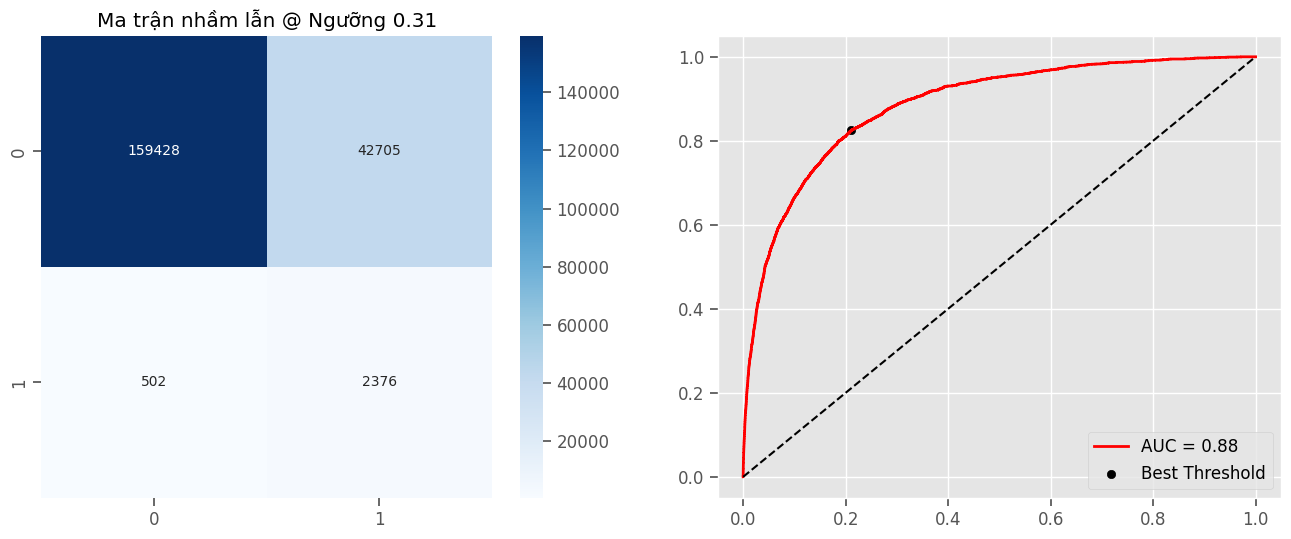

In [52]:
# Theo nguyên tác code, thực hiện RandomizedSearchCV
param_dist = {
    'num_leaves': [31, 50, 70],
    'max_depth': [10, 15, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 1000],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
}

lgb_base = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
random_search = RandomizedSearchCV(lgb_base, param_dist, n_iter=10, scoring='roc_auc', cv=3, verbose=1, random_state=42)
random_search.fit(X_train_res, y_train_res)

print(f"Tham số tốt nhất: {random_search.best_params_}")

# Huấn luyện model cuối
model = lgb.LGBMClassifier(**random_search.best_params_, random_state=42, n_jobs=-1, verbose=-1)
model.fit(X_train_res, y_train_res, eval_set=[(X_test_proc, y_test)], 
          eval_metric='auc', callbacks=[lgb.early_stopping(stopping_rounds=50)])

y_prob = model.predict_proba(X_test_proc)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
ix = np.argmax(np.sqrt(tpr * (1-fpr)))
best_threshold = thresholds[ix]

print(f"   -> Ngưỡng tối ưu (Best Threshold): {best_threshold:.4f}")
y_pred = (y_prob >= best_threshold).astype(int)

print("\n--- BÁO CÁO PHÂN LOẠI ---")
print(classification_report(y_test, y_pred, target_names=['Bình thường', 'Gian lận']))

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title(f'Ma trận nhầm lẫn @ Ngưỡng {best_threshold:.2f}')

ax[1].plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}', color='red', lw=2)
ax[1].scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold')
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].legend()
plt.show()